In [49]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import tqdm
import re
import itertools

import datatable as dt
import seaborn as sns
import umap.umap_ as umap

from sklearn.cluster import AgglomerativeClustering

Clustering without a model

In [76]:
path = r"C:\Users\Acer\Git\deda_punks\Crypto_punks\for sale"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
punks = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # add the image files to the list
            punks.append(file.name)

In [77]:
punks_img = []
for image in tqdm.tqdm(punks):
    punks_img.append(plt.imread(image).flatten())
    
punks_img = np.stack(punks_img)

100%|████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:00<00:00, 1657.75it/s]


In [48]:
brain_umap = umap.UMAP(random_state=999)

# Fit UMAP and extract latent vars 1-2
embedding = pd.DataFrame(brain_umap.fit_transform(punks_img), columns = ['UMAP1','UMAP2'])

In [82]:
clustered = AgglomerativeClustering(linkage = "average", n_clusters=200)
clustered.fit(punks_img)

AgglomerativeClustering(linkage='average', n_clusters=200)

In [107]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [84]:
Z = linkage(punks_img)

In [86]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
c, coph_dists = cophenet(Z, pdist(punks_img))

In [111]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

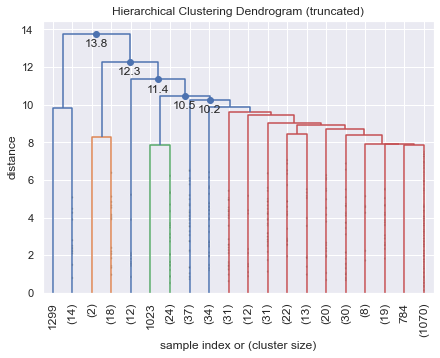

In [116]:
sns.set(rc={'figure.figsize':(7, 5)})
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [79]:
# holds the cluster id and the images { id: [images] }

def post_process_clustering (model):
    groups = {}
    for file, cluster in zip(punks,model.labels_):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups

In [80]:
groups = post_process_clustering(clustered)

Clustering with the model

In [119]:
path = r"C:\Users\Acer\Git\deda_punks\Crypto_punks\for sale"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
punks = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the list
            punks.append(file.name)

In [120]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [121]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [125]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [126]:
data = {}
p = r"C:\Users\Acer\Git\deda_punks\punks_features_.pkl"

# lop through each image in the dataset
for punk in tqdm.tqdm(punks):
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(punk,model)
        data[punk] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

100%|██████████████████████████████████████████████████████████████████████████████| 1400/1400 [13:31<00:00,  1.73it/s]


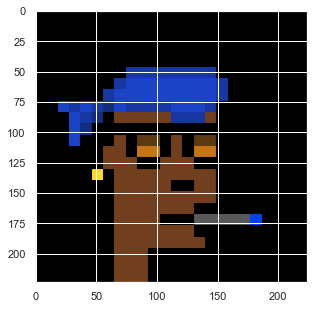

In [127]:
img = load_img(r"C:\Users\Acer\Git\deda_punks\Crypto_punks\bids\Punk 0310.png", target_size=(224,224))
img2 = np.array(img)
plt.imshow(img2, interpolation=None)

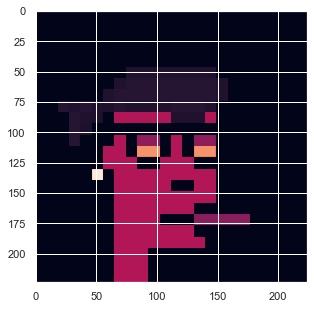

In [128]:
from matplotlib import pyplot as plt
plt.imshow(img2[:,:,0], interpolation=None)
#plt.show()
plt.imsave(r'C:\Users\Acer\Git\deda_punks\R__.png', img2[:,:,0])
#red

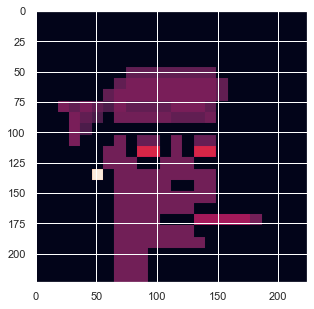

In [129]:
from matplotlib import pyplot as plt
plt.imshow(img2[:,:,1], interpolation=None)
#plt.show()
plt.imsave(r'C:\Users\Acer\Git\deda_punks\G__.png', img2[:,:,1])
#green

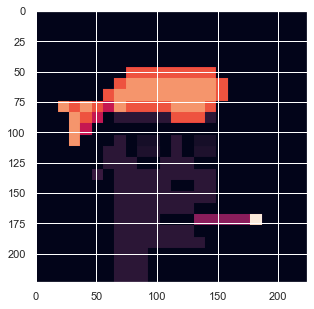

In [130]:
from matplotlib import pyplot as plt
plt.imshow(img2[:,:,2], interpolation=None)
#plt.show()
plt.imsave(r'C:\Users\Acer\Git\deda_punks\B__.png', img2[:,:,2])
#blue

In [131]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
print(feat.shape)

(1400, 1, 4096)
(1400, 4096)


In [132]:
pca = PCA(n_components=150, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

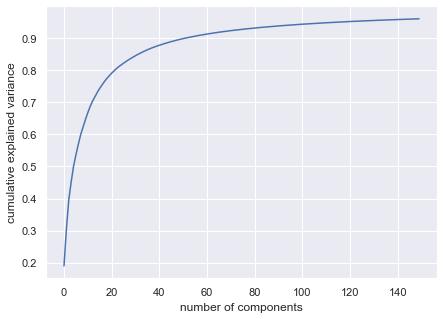

In [133]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig(r"C:\Users\Acer\Git\deda_punks\PCA.png")
# 150 components explain almost 95% of the variance

In [134]:
feat.shape

(1400, 4096)

In [135]:
from sklearn.cluster import AgglomerativeClustering

In [136]:
clustered = AgglomerativeClustering(n_clusters=200, linkage = "average")
clustered.fit(x)

AgglomerativeClustering(linkage='average', n_clusters=200)

In [137]:
# holds the cluster id and the images { id: [images] }

def post_process_clustering (model):
    groups = {}
    for file, cluster in zip(filenames,model.labels_):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups

In [138]:
groups = post_process_clustering(clustered)

In [139]:
#pic_cluster_id = []
from PIL import Image
for i in range(0,3): # display first 3 clusters
    print("Cluster_ID", i)
    for mini_punk in groups[i]:
        img = Image.open(r"C:\Users\Acer\Git\deda_punks\Crypto_punks\for sale\\"+mini_punk)  
        display (img)
        print(mini_punk)
        #pic_cluster_id.append([display(img), i])


Cluster_ID 0


Punk 2071.png


Punk 2348.png


Punk 2483.png


Punk 3310.png


Punk 3591.png


Punk 6007.png


Punk 8375.png


Punk 8508.png


Punk 8624.png


Punk 8876.png


Punk 8908.png


Punk 9236.png


Punk 9862.png
Cluster_ID 1


Punk 0824.png


Punk 4506.png


Punk 5690.png


Punk 7261.png


Punk 7407.png


Punk 7656.png


Punk 7996.png


Punk 8785.png


Punk 9129.png


Punk 9749.png
Cluster_ID 2


Punk 1968.png


Punk 2539.png


Punk 6105.png


Punk 6615.png


Punk 6809.png


Punk 7316.png


Punk 8395.png


Punk 8564.png


In [148]:
os.chdir(r"C:\Users\Acer\Git\deda_punks\data")

def merge_punks_to_clusters () :
    scraped = pd.read_csv(r"all_offered_punks_.csv")
    cluster_names = pd.read_csv(r"punks cluster names.csv")

    cluster_names.rename({"Punk Name":"Punk_ID", "Cluster Group":"Cluster_ID"}, axis = 1, inplace = True)
    cluster_names["Punk_ID_png"] = cluster_names["Punk_ID"].copy()
    cluster_names.Punk_ID = list(itertools.chain(*cluster_names.Punk_ID.apply(lambda x: re.findall("(\d+)", x))))

    cluster_names.Punk_ID = cluster_names.Punk_ID.astype(int)
    cluster_names.Cluster_ID = cluster_names.Cluster_ID.astype(int)

    scraped = scraped.merge(cluster_names, on = "Punk_ID", how="left")
    scraped = scraped[scraped.Cluster_ID.isnull()==False]
    
    scraped.Cluster_ID = scraped.Cluster_ID.astype(int)
    return scraped

In [149]:
df = merge_punks_to_clusters()

In [151]:
df = df[df.Cluster_ID.isin([7, 114, 120, 143, 195])].copy()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path))

paths = [
    'a.jpg',
    'b.jpg',
    'c.jpg',
    'd.jpg',
    'e.jpg']

x = [0,1,2,3,4]
y = [0,1,2,3,4]

fig, ax = plt.subplots()
ax.scatter(x, y) 

for x0, y0, path in zip(df, y, df.Punk_ID_png):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)